# Test of ESIS Reproducibility
_Roy Smart and Charles Kankelborg_

Set up environment and import required packages.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import pandas as pd
import kgpy.optics
import kgpy.vector
import esis.optics

warnings.filterwarnings('ignore')

In [2]:
pupil_samples = 21
field_samples = 5

esis_optics_small = esis.optics.design.final(pupil_samples=5, field_samples=5)
esis_optics = esis.optics.design.final(pupil_samples=pupil_samples, field_samples=field_samples)

In [3]:
new_esis_optics = esis.optics.design.final_from_poletto(
    pupil_samples=pupil_samples, 
    field_samples=field_samples,
    use_toroidal_grating=False,
    use_vls_grating=True,
    use_one_wavelength_detector_tilt=True,
)
new_esis_optics_small = new_esis_optics.copy()
new_esis_optics_small.pupil_samples = esis_optics_small.pupil_samples
new_esis_optics_small.field_samples = esis_optics_small.field_samples
new_esis_optics_small.update()

## Layout

<IPython.core.display.Javascript object>


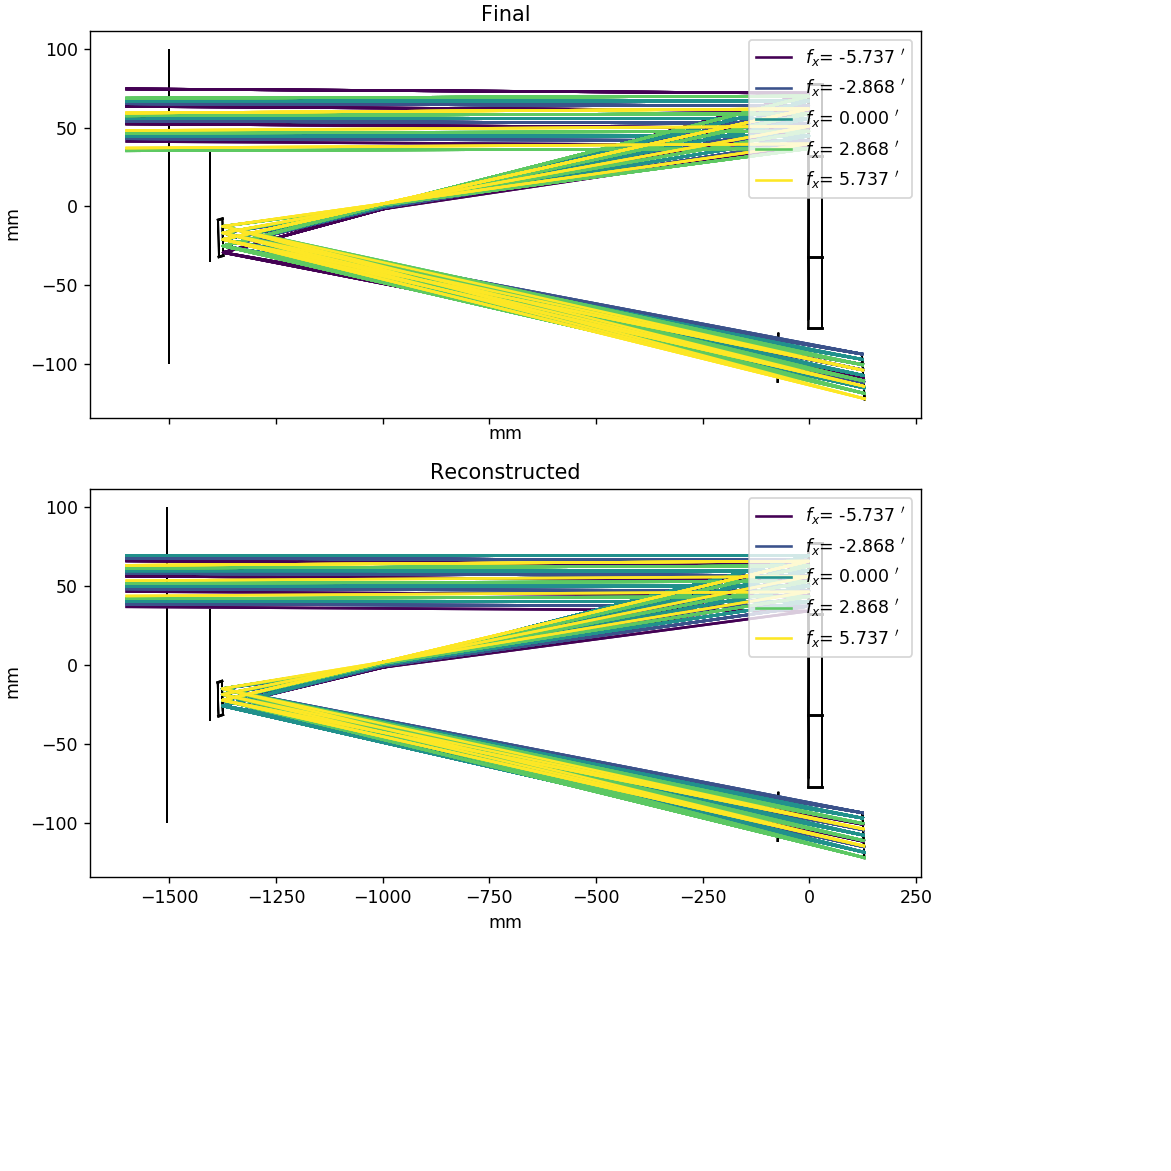

In [4]:
name_old = 'Final'
name_new = 'Reconstructed'
color_axis = kgpy.optics.Rays.axis.field_x
fig_layout, axs_layout = plt.subplots(
    nrows=2, 
    figsize=(7.5, 7.5), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot(
    ax=axs_layout[0],
    components=(kgpy.vector.iz, kgpy.vector.ix),
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot(
    ax=axs_layout[1],
    components=(kgpy.vector.iz, kgpy.vector.ix),
    color_axis=color_axis,
)
_ = axs_layout[0].set_title(name_old)
_ = axs_layout[1].set_title(name_new)
# _ = axs_layout[0].axis('equal')
# _ = axs_layout[1].axis('equal')

<IPython.core.display.Javascript object>


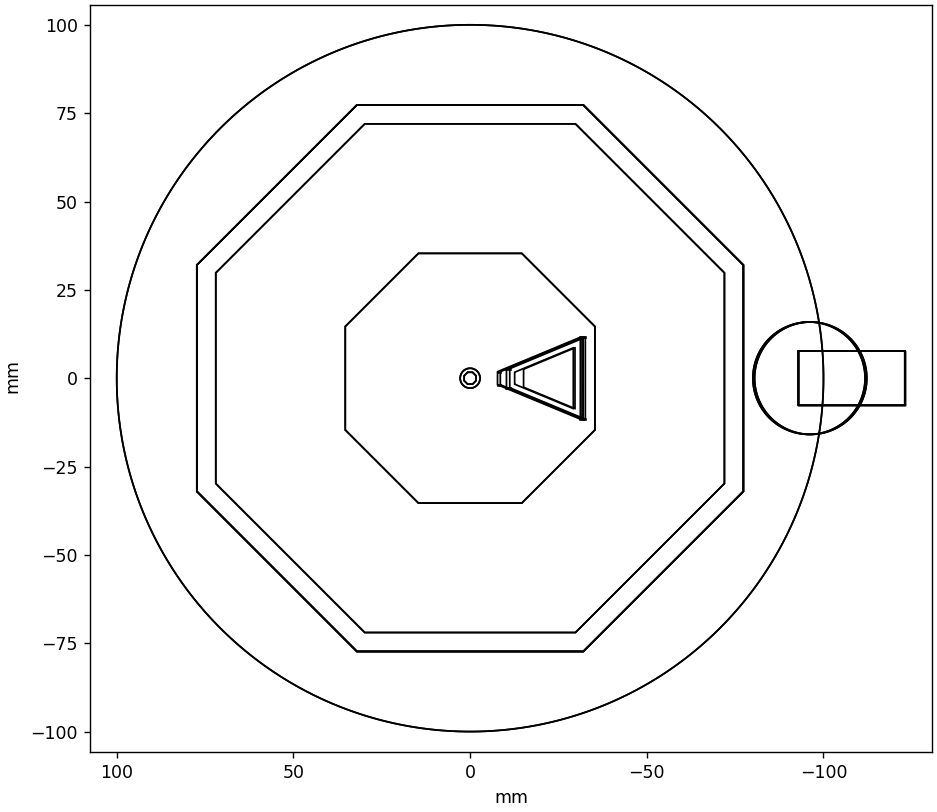

In [5]:
fig_bore, ax_bore = plt.subplots(
    figsize=(7.5, 6.5), 
    constrained_layout=True,
)
ax_bore.invert_xaxis()
_ = esis_optics_small.system.plot(
    ax=ax_bore,
    plot_rays=False,
)
_ = new_esis_optics_small.system.plot(
    ax=ax_bore,
    plot_rays=False,
)
_ = ax_bore.axis('equal')

In [6]:
c_old = esis_optics.components
c_new = new_esis_optics.components

In [7]:
pd.concat([c_old.source.dataframe, c_new.source.dataframe], ignore_index=True)

,name,piston,half width,half height
0,sun,1600.000 $\mathrm{mm}$,5.737 $\mathrm{{}^{\prime}}$,5.737 $\mathrm{{}^{\prime}}$
1,sun,1600.000 $\mathrm{mm}$,5.737 $\mathrm{{}^{\prime}}$,5.737 $\mathrm{{}^{\prime}}$


## Front Aperture Plate

In [8]:
pd.concat([c_old.front_aperture.dataframe, c_new.front_aperture.dataframe], ignore_index=True)

,name,piston,clear radius
0,front aperture,1500.000 $\mathrm{mm}$,100.000 $\mathrm{mm}$
1,front aperture,1505.347 $\mathrm{mm}$,100.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


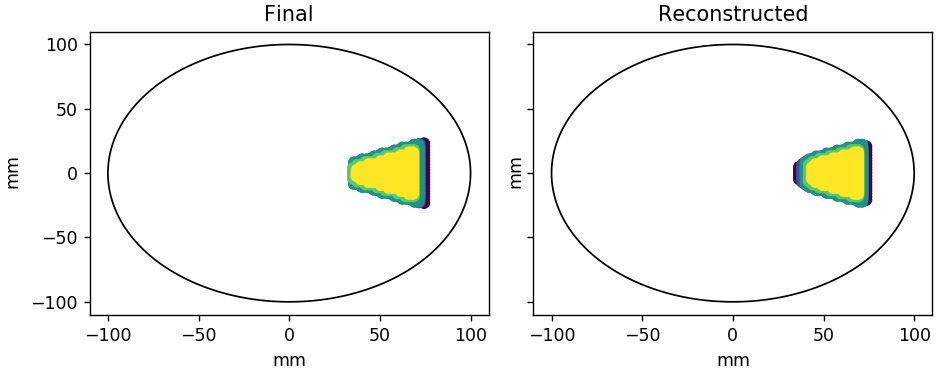

In [9]:
fig_front_aper, axs_front_aper = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_front_aper[0],
    surf=esis_optics.components.front_aperture.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_front_aper[1],
    surf=new_esis_optics.components.front_aperture.surface,
    color_axis=color_axis,
)
axs_front_aper[0].get_legend().remove()
axs_front_aper[1].get_legend().remove()
_ = axs_front_aper[0].set_title(name_old)
_ = axs_front_aper[1].set_title(name_new)

## Central Obscuration

In [10]:
pd.concat([c_old.central_obscuration.dataframe, c_new.central_obscuration.dataframe], ignore_index=True)

,name,piston,obscured radius,number of sides
0,obscuration,1404.270 $\mathrm{mm}$,38.223 $\mathrm{mm}$,8
1,obscuration,1405.347 $\mathrm{mm}$,38.256 $\mathrm{mm}$,8


<IPython.core.display.Javascript object>


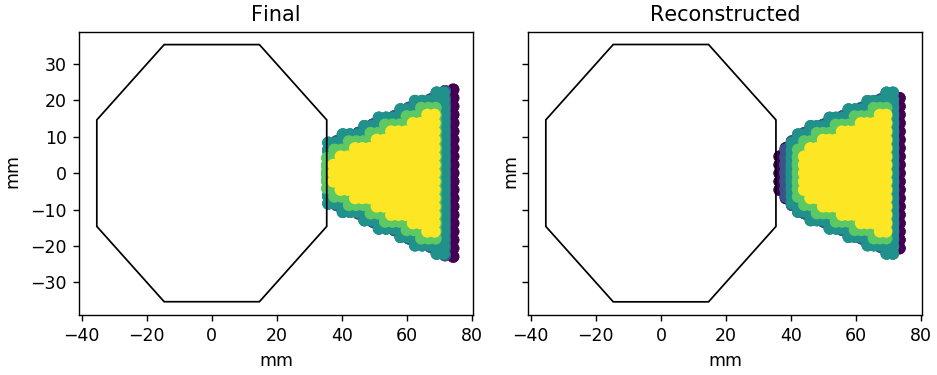

In [11]:
fig_obscuration, axs_obscuration = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_obscuration[0],
    surf=esis_optics.components.central_obscuration.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_obscuration[1],
    surf=new_esis_optics.components.central_obscuration.surface,
    color_axis=color_axis,
)
axs_obscuration[0].get_legend().remove()
axs_obscuration[1].get_legend().remove()
_ = axs_obscuration[0].set_title(name_old)
_ = axs_obscuration[1].set_title(name_new)

## Primary Mirror

In [12]:
pd.concat([c_old.primary.dataframe, c_new.primary.dataframe], ignore_index=True)

,name,piston,radius,conic constant,number of sides,clear radius,border width,substrate thickness
0,primary,0.000 $\mathrm{mm}$,2000.000 $\mathrm{mm}$,-1.000 $\mathrm{}$,8,77.900 $\mathrm{mm}$,5.800 $\mathrm{mm}$,30.000 $\mathrm{mm}$
1,primary,0.000 $\mathrm{mm}$,2000.000 $\mathrm{mm}$,-1.000 $\mathrm{}$,8,77.900 $\mathrm{mm}$,5.800 $\mathrm{mm}$,30.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


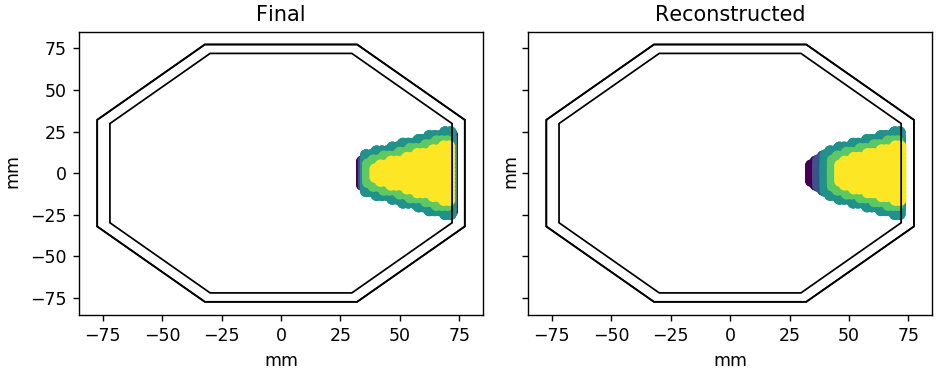

In [13]:
fig_primary, axs_primary = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_primary[0],
    surf=esis_optics.components.primary.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_primary[1],
    surf=new_esis_optics.components.primary.surface,
    color_axis=color_axis,
)
axs_primary[0].get_legend().remove()
axs_primary[1].get_legend().remove()
_ = axs_primary[0].set_title(name_old)
_ = axs_primary[1].set_title(name_new)

## Field Stop

In [14]:
pd.concat([c_old.field_stop.dataframe, c_new.field_stop.dataframe], ignore_index=True)

,name,piston,clear radius,mechanical radius,number of sides
0,field stop,1000.000 $\mathrm{mm}$,1.820 $\mathrm{mm}$,2.810 $\mathrm{mm}$,8
1,field stop,1000.000 $\mathrm{mm}$,1.822 $\mathrm{mm}$,2.810 $\mathrm{mm}$,8


<IPython.core.display.Javascript object>


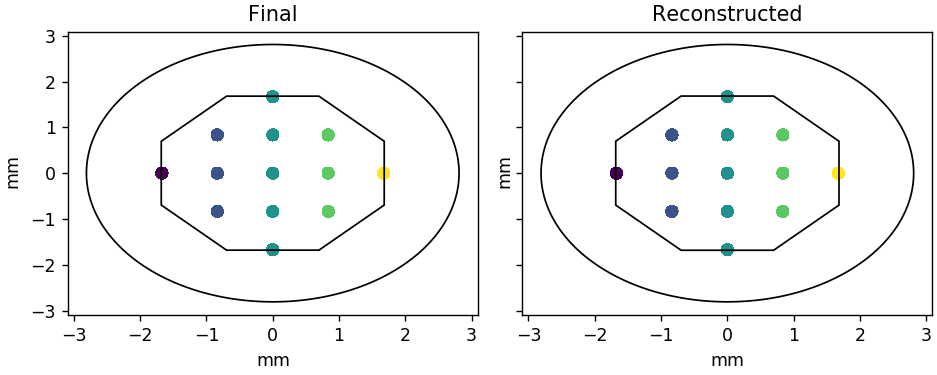

In [15]:
fig_field_stop, axs_field_stop = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_field_stop[0],
    surf=esis_optics.components.field_stop.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_field_stop[1],
    surf=new_esis_optics.components.field_stop.surface,
    color_axis=color_axis,

)
axs_field_stop[0].get_legend().remove()
axs_field_stop[1].get_legend().remove()
_ = axs_field_stop[0].set_title(name_old)
_ = axs_field_stop[1].set_title(name_new)

## Grating

In [16]:
pd.concat([c_old.grating.dataframe, c_new.grating.dataframe], ignore_index=True)

,name,piston,cylindrical radius,cylindrical azimuth,inclination,tangential radius,sagittal radius,nominal alpha,nominal beta,diffraction order,...,cubic ruling coefficient,aperture wedge half-angle,aperture cylindrical radius,inner clear radius,outer clear radius,inner border width,outer border width,side border width,dynamic clearance,substrate thickness
0,grating,1374.700 $\mathrm{mm}$,20.750 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-4.470 $\mathrm{{}^{\circ}}$,597.830 $\mathrm{mm}$,597.830 $\mathrm{mm}$,1.301 $\mathrm{{}^{\circ}}$,8.057 $\mathrm{{}^{\circ}}$,1.000 $\mathrm{}$,...,0.000e+00 $\mathrm{\frac{1}{mm^{4}}}$,22.500 $\mathrm{{}^{\circ}}$,-20.750 $\mathrm{mm}$,12.590 $\mathrm{mm}$,29.240 $\mathrm{mm}$,4.860 $\mathrm{mm}$,2.000 $\mathrm{mm}$,2.000 $\mathrm{mm}$,1.250 $\mathrm{mm}$,10.000 $\mathrm{mm}$
1,grating,1375.777 $\mathrm{mm}$,20.750 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-5.311 $\mathrm{{}^{\circ}}$,598.534 $\mathrm{mm}$,598.534 $\mathrm{mm}$,2.151 $\mathrm{{}^{\circ}}$,8.634 $\mathrm{{}^{\circ}}$,1.000 $\mathrm{}$,...,0.000e+00 $\mathrm{\frac{1}{mm^{4}}}$,22.500 $\mathrm{{}^{\circ}}$,-20.292 $\mathrm{mm}$,14.654 $\mathrm{mm}$,29.273 $\mathrm{mm}$,4.860 $\mathrm{mm}$,2.000 $\mathrm{mm}$,2.000 $\mathrm{mm}$,1.250 $\mathrm{mm}$,10.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


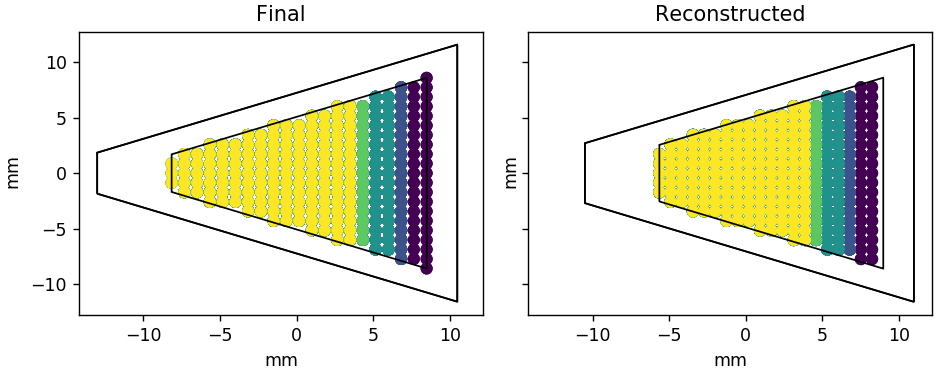

In [17]:
fig_grating, axs_grating = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_grating[0],
    surf=esis_optics.components.grating.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_grating[1],
    surf=new_esis_optics.components.grating.surface,
    color_axis=color_axis,
)
axs_grating[0].get_legend().remove()
axs_grating[1].get_legend().remove()
_ = axs_grating[0].set_title(name_old)
_ = axs_grating[1].set_title(name_new)

## Filter

In [18]:
pd.concat([c_old.filter.dataframe, c_new.filter.dataframe], ignore_index=True)

,name,piston,cylindrical radius,cylindrical azimuth,inclination,clear radius,border width
0,filter,73.038 $\mathrm{mm}$,95.900 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-3.450 $\mathrm{{}^{\circ}}$,15.900 $\mathrm{mm}$,0.000 $\mathrm{mm}$
1,filter,73.038 $\mathrm{mm}$,96.381 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-3.323 $\mathrm{{}^{\circ}}$,15.900 $\mathrm{mm}$,0.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


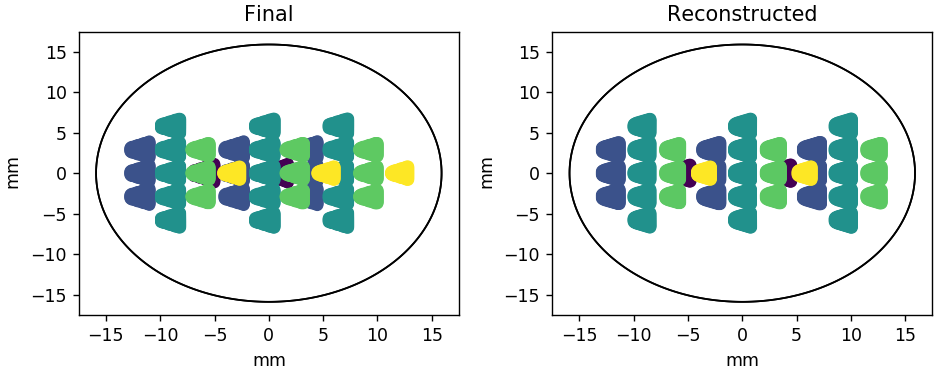

In [19]:
fig_filter, axs_filter = plt.subplots(ncols=2, figsize=(7.5, 3), constrained_layout=True)
_ = esis_optics.system.plot_footprint(
    ax=axs_filter[0],
    surf=esis_optics.components.filter.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_filter[1],
    surf=new_esis_optics.components.filter.surface,
    color_axis=color_axis,
)
axs_filter[0].get_legend().remove()
axs_filter[1].get_legend().remove()
_ = axs_filter[0].set_title(name_old)
_ = axs_filter[1].set_title(name_new)

## Detector

In [20]:
pd.concat([c_old.detector.dataframe, c_new.detector.dataframe], ignore_index=True)

,name,piston,cylindrical radius,cylindrical azimuth,inclination,pixel width,pixel array shape,right border width,left border width,top border width,bottom border width,dynamic clearance
0,detector,-126.962 $\mathrm{mm}$,108.000 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-12.252 $\mathrm{{}^{\circ}}$,15.000 $\mathrm{\mu m}$,"(2048, 1024)",0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$
1,detector,-127.089 $\mathrm{mm}$,108.000 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-8.899 $\mathrm{{}^{\circ}}$,15.000 $\mathrm{\mu m}$,"(2048, 1024)",0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$,20.670 $\mathrm{mm}$


<IPython.core.display.Javascript object>


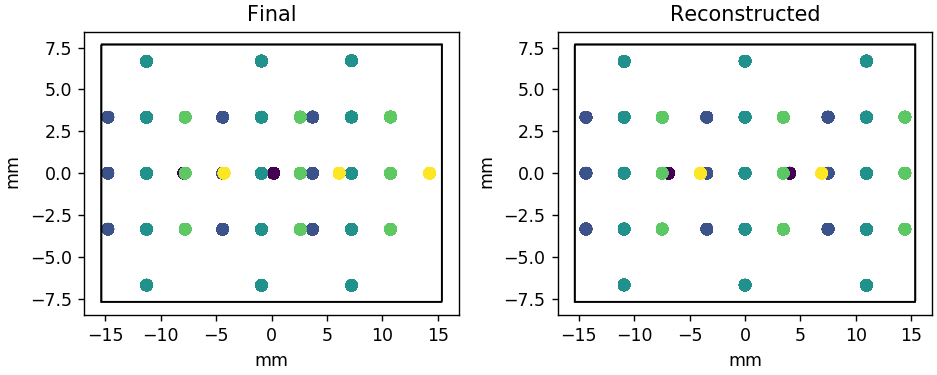

In [21]:
fig_detector, axs_detector = plt.subplots(ncols=2, figsize=(7.5, 3), constrained_layout=True)
_ = esis_optics.system.plot_footprint(
    ax=axs_detector[0],
    surf=esis_optics.components.detector.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_detector[1],
    surf=new_esis_optics.components.detector.surface,
    color_axis=color_axis,
)
axs_detector[0].get_legend().remove()
axs_detector[1].get_legend().remove()
_ = axs_detector[0].set_title(name_old)
_ = axs_detector[1].set_title(name_new)

## Spot diagrams for final ESIS design

<IPython.core.display.Javascript object>


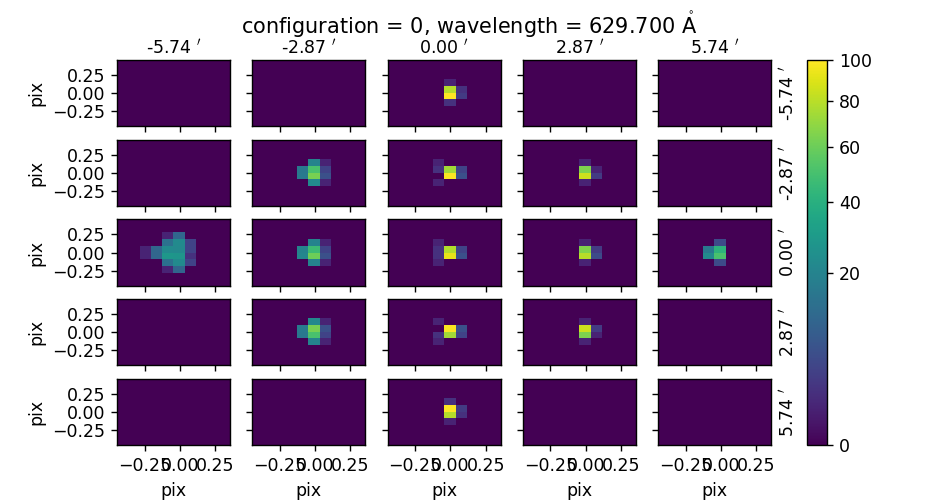

<IPython.core.display.Javascript object>


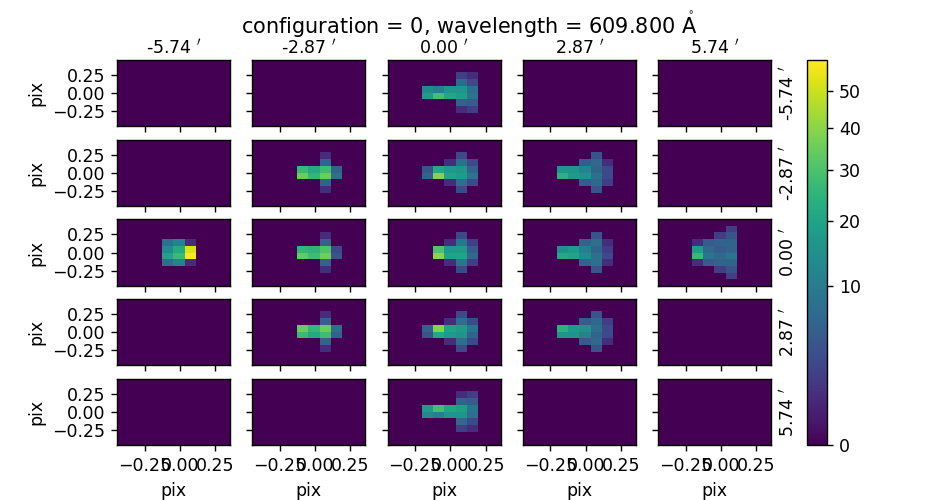

<IPython.core.display.Javascript object>


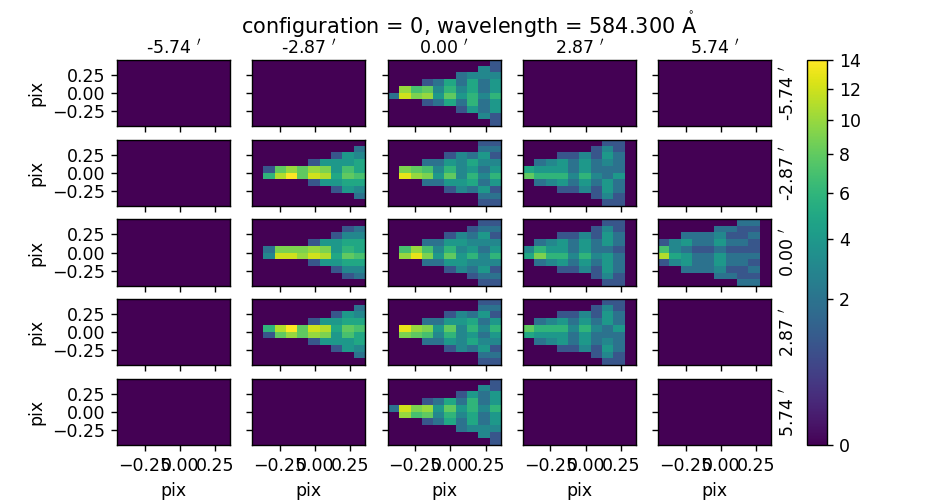

In [22]:
rays = esis_optics.system.rays_output.copy()
rays.position = (rays.position / (esis_optics.components.detector.pixel_width / u.pix)).to(u.pix)
for w in range(rays.input_grids[rays.axis.wavelength].shape[~0]):
    fig = rays.plot_pupil_hist2d_vs_field(
        wavlen_index=w,
        relative_to_centroid=(True, True),
        norm=matplotlib.colors.PowerNorm(1/2),
    )
    fig.set_figheight(4)
    fig.set_figwidth(7.5)

## Spot diagrams for reconstructed ESIS design

<IPython.core.display.Javascript object>


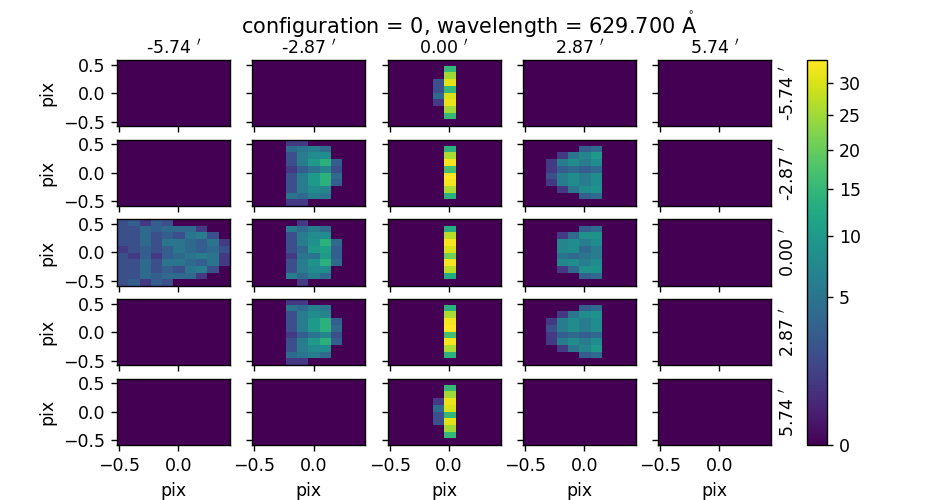

<IPython.core.display.Javascript object>


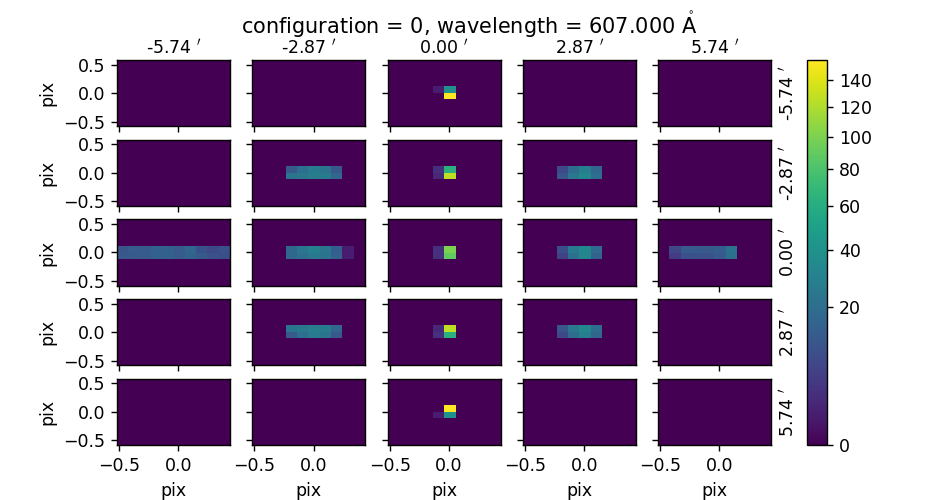

<IPython.core.display.Javascript object>


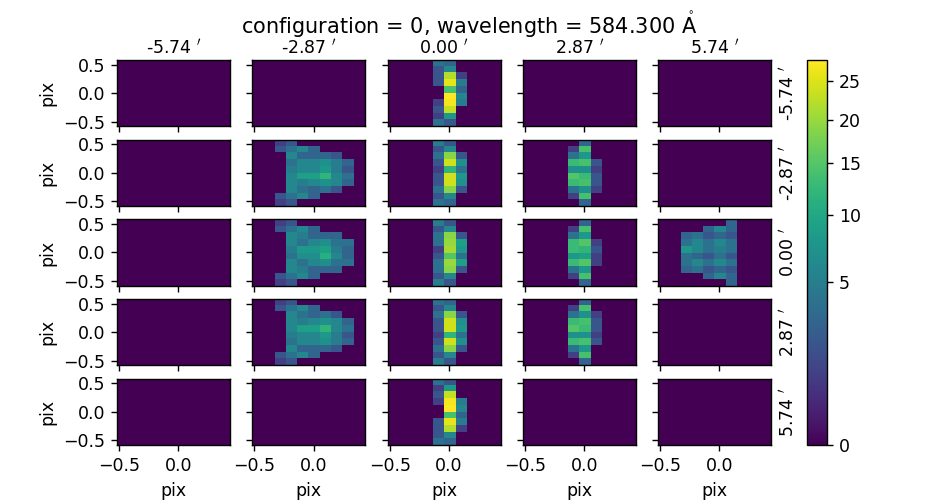

In [23]:
rays = new_esis_optics.system.rays_output.copy()
rays.position = (rays.position / (esis_optics.components.detector.pixel_width / u.pix)).to(u.pix)
for w in range(rays.input_grids[rays.axis.wavelength].shape[~0]):
    fig = rays.plot_pupil_hist2d_vs_field(
        wavlen_index=w,
        relative_to_centroid=(True, True),
        norm=matplotlib.colors.PowerNorm(1/2),
    )
    fig.set_figheight(4)
    fig.set_figwidth(7.5)
